# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wget
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=55559fdd39c7705fc8d2b40b73cfcea48a1765da359bbb2a73afa7d4bf1df9c9
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Support functions and variables

In [27]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")

'ml-100k (1).zip'

In [28]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [29]:
MOVIELENS_DIR = "ml-100k"

In [5]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [6]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [30]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [8]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [9]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [10]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [11]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [12]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.

        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'

        NOTE 2: data can have more columns, but your function should ignore
              additional columns.
    """
    ########### your code goes here ###########

    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    ###########         end         ###########
    return matrix

In [13]:
a = dataPreprocessor(rating_df,  len(rating_df.userID.unique()),  len(rating_df.itemID.unique()))
print(a.shape)

(943, 1682)


In [15]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }

        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):

        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.__model = None
        except:
            print("You don not have model..")


In [16]:
popularity_recsys = BaseLineRecSys('popularity')

In [17]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [18]:
x = popularity_recsys.getModel()

In [19]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.        , 0.37333333, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
np.all(x<=1)

True

In [21]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [22]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3957.19it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [23]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [24]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [25]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [26]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:04, 4531.02it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [76]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }

        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean'))

        ###########         end         ###########

        return similarity_matrix

    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 - pairwise_distances(matrix, metric = 'manhattan')

        ###########         end         ###########
        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model

            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)

        if self.base == 'user':
            ########### your code goes here ###########

            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)

            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer

            self.__model = predictionMatrix

            ###########         end         ###########

        elif self.base == 'item':
            ########### your code goes here ###########

            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)

            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer==0] = 1e-5

            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

            self.__model = predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.__model = None
        except:
            print("You do not have model..")

Cosine is a better metric over euclidean since for euclidean, the size of the vector makes a difference even if they are actually similar unlike cosine.

In [77]:
# Examples of how to call similarity functions.
# I = np.eye(3)
I = np.array([[3,0,2, 3],[0,5,3, 4], [3,3,5, 1], [0,5,0, 0], [3,5,0, 3]])
print(I[[True,False, False, True, True]])

[[3 0 2 3]
 [0 5 0 0]
 [3 5 0 3]]


In [78]:
SimBasedRecSys.cosine(I)

array([[1.        , 0.54272042, 0.70710678, 0.        , 0.58523048],
       [0.54272042, 1.        , 0.72488244, 0.70710678, 0.79796252],
       [0.70710678, 0.72488244, 1.        , 0.45226702, 0.62073066],
       [0.        , 0.70710678, 0.45226702, 1.        , 0.76249285],
       [0.58523048, 0.79796252, 0.62073066, 0.76249285, 1.        ]])

In [79]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.14285714, 0.17573408, 0.12729684, 0.15661303],
       [0.14285714, 1.        , 0.16396078, 0.16666667, 0.1866055 ],
       [0.17573408, 0.16396078, 1.        , 0.13802626, 0.14826758],
       [0.12729684, 0.16666667, 0.13802626, 1.        , 0.19074357],
       [0.15661303, 0.1866055 , 0.14826758, 0.19074357, 1.        ]])

In [80]:
SimBasedRecSys.somethingelse(I)

array([[  1.,  -9.,  -7., -12.,  -6.],
       [ -9.,   1.,  -9.,  -6.,  -6.],
       [ -7.,  -9.,   1., -10.,  -8.],
       [-12.,  -6., -10.,   1.,  -5.],
       [ -6.,  -6.,  -8.,  -5.,   1.]])

### (b)

I chose the Manhatten distance for user/item comparison because it effectively handles independent features.

##Q3

### (a)

In [81]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [82]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [83]:
user_cosine_recsys.getModel()


array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [84]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [85]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:04, 4445.98it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [86]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [87]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [88]:
item_cosine_recsys.getModel()

array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [89]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3878.38it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)

user-user had a rmse avg of 0.4736 with a CI of [0.37, 0.70] while item-item was not reported in the results. Here, user-user may perform better when users have similar preferences and if there are sufficient number of ratings availablle, while item-item can perform better when items receive many ratings such that the similarity between items is easier to calculate.

In [90]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)

    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }

        return switcher[metric_name]

    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))

    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)

        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions

    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))

        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value

        return matrix

    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds

    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms.
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """

        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                display(prediction.head())
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))

            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]

        results = scores

        return results


In [ ]:
# How to use CrossValidation Class?

In [91]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys]

In [92]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [93]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4286.32it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3925.25it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5145.51it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5237.63it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5192.12it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5148.76it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4198.54it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5067.34it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3832.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5095.66it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:04, 4794.16it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:03, 5013.56it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:04, 4813.81it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:04, 4930.84it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:03, 5028.17it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943]}

##Q4

(a)

## PMF

In [115]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=15, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)

        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item

            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user

        """
        # select 'userID', 'itemID', 'rating only

        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating


        # to avoid out of bound
        num_user += 1
        num_item += 1
        # initialize
        self.epoch = 0
        ########### your code goes here ###########
        self.w_Item = np.random.randn(num_item, self.num_feat)
        self.w_User = np.random.randn(num_user, self.num_feat)
        ###########         end         ###########

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute mean rating subtracted rating
                ########### your code goes here ###########
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID], self.w_Item[batch_ItemID]), axis=1)

                ###########         end         ###########

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx], self.w_Item[train_item_idx]), axis=1)

                    ###########         end         ###########
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2]
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx], self.w_Item[val_item_idx]), axis=1)

                    ###########         end         ###########

                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))





    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]

        return prediction

    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None
            self.w_User = None
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [113]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 15, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

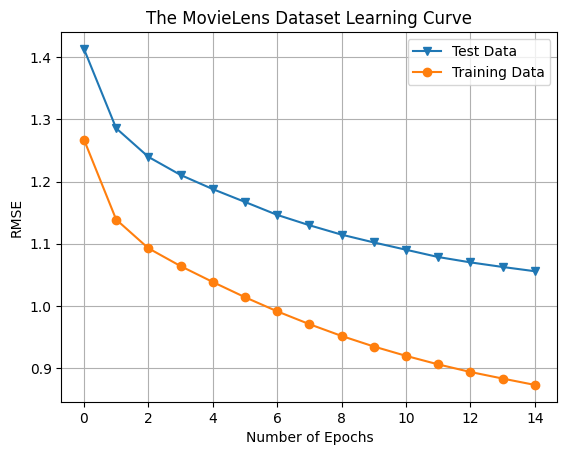

In [114]:
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

##Q5

### (a)

In [126]:
algorithm_instances = [
    popularity_recsys, average_user_rating_recsys, user_cosine_recsys, item_cosine_recsys, pmf]

cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')

rmse_results = cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
patk_results = cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
ratk_results = cv_ratk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4154.98it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2893.22it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1912.91it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3855.98it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5071.89it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2870.49it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4987.90it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4536.22it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2228.22it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3398.30it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:06, 3012.07it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:10, 1966.93it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:04, 4887.03it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:04, 4680.70it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:05, 3975.26it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:04, 4540.50it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:06, 3059.79it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:04, 4719.73it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:04, 4389.23it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:04, 4125.59it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:11, 1717.45it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.569628
1,1,10,3,3.848799
2,1,12,5,5.123834
3,1,14,5,3.931015
4,1,17,3,3.398459


20000it [00:08, 2462.74it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.270364
1,1,2,3,3.214667
2,1,8,1,4.248075
3,1,9,5,3.875255
4,1,21,1,1.944834


20000it [00:10, 1944.10it/s]


,userID,itemID,rating,PMF
0,1,5,3,3.090873
1,1,11,2,4.187477
2,1,16,5,3.323825
3,1,25,4,3.362375
4,1,35,1,2.162389


20000it [00:10, 1910.40it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.902937
1,1,7,4,3.831152
2,1,42,5,3.395741
3,1,43,4,3.319190
4,1,55,5,4.054471


20000it [00:10, 1907.39it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.735129
1,1,13,5,3.513096
2,1,15,5,3.890983
3,1,18,4,1.095204
4,1,19,5,4.098430


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3743.11it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4473.09it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:03, 5002.89it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4929.47it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4971.36it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4740.71it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4616.15it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4888.89it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3547.99it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4775.38it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:05, 3539.44it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:04, 4663.69it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:05, 3524.90it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:04, 4702.37it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:05, 3549.77it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:04, 4543.20it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:05, 3440.22it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:04, 4555.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:05, 3404.80it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:04, 4522.00it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:11, 1795.13it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.348205
1,1,10,3,3.356593
2,1,12,5,4.332767
3,1,14,5,4.285098
4,1,17,3,3.098357


20000it [00:10, 1841.74it/s]


,userID,itemID,rating,PMF
0,1,1,5,3.901516
1,1,2,3,3.125754
2,1,8,1,4.384105
3,1,9,5,4.361220
4,1,21,1,2.443589


20000it [00:08, 2397.54it/s]


,userID,itemID,rating,PMF
0,1,5,3,3.225070
1,1,11,2,4.271010
2,1,16,5,2.922921
3,1,25,4,3.291169
4,1,35,1,4.554890


20000it [00:15, 1284.80it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.689349
1,1,7,4,4.089130
2,1,42,5,4.059065
3,1,43,4,2.925991
4,1,55,5,3.902702


20000it [00:14, 1372.23it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.709355
1,1,13,5,3.697375
2,1,15,5,3.881286
3,1,18,4,2.503953
4,1,19,5,4.228982


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4749.99it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3637.25it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4135.90it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4742.38it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4557.25it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4682.00it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3503.14it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4623.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4706.20it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3980.38it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:04, 4559.83it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:05, 3888.74it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:05, 3980.95it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:10, 1898.63it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:05, 3418.91it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:04, 4512.54it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:06, 3326.32it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:04, 4435.55it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:05, 3373.82it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:08, 2478.36it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:11, 1717.69it/s]


,userID,itemID,rating,PMF
0,1,6,5,2.853753
1,1,10,3,4.163063
2,1,12,5,4.544611
3,1,14,5,3.477676
4,1,17,3,4.095483


20000it [00:09, 2145.11it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.195515
1,1,2,3,3.277549
2,1,8,1,4.238183
3,1,9,5,4.404367
4,1,21,1,2.351763


20000it [00:12, 1598.16it/s]


,userID,itemID,rating,PMF
0,1,5,3,3.557030
1,1,11,2,4.011590
2,1,16,5,3.174528
3,1,25,4,3.442926
4,1,35,1,3.411441


20000it [00:12, 1665.64it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.780061
1,1,7,4,3.956738
2,1,42,5,3.448079
3,1,43,4,3.107180
4,1,55,5,3.975378


20000it [00:10, 1862.82it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.684348
1,1,13,5,3.359905
2,1,15,5,3.547604
3,1,18,4,2.335703
4,1,19,5,3.660727


In [124]:
print('RMSE')
for key, value in rmse_results.items():
  print(key, value[1].round(4))

print('P@K')
for key, value in patk_results.items():
  print(key, value[1].round(4))

print('R-Precision')
for key,value in ratk_results.items():
  print(key, value[1].round(4))

RMSE
popularity 3.1591
useraverage 1.0437
user-cosine 1.0222
item-cosine 1.0201
PMF 1.1198
P@K
popularity 0.5506
useraverage 0.4736
user-cosine 0.5558
item-cosine 0.5322
PMF 0.4931
R-Precision
popularity 0.4841
useraverage 0.4413
user-cosine 0.4863
item-cosine 0.475
PMF 0.4489


### (b)

Popularity and user avg cannot be meaningfully evaluated using ranking metrics like P@k or R-Precision since these baselines dont generate personalized rankings for each other. They simply recommend the same popular or average-related items to everyone, without considering relevance of individual items for each user.

### (c)


* Best for RMSE: Item-Cosine (due to better accuracy in predicting individual ratings).
* Best for P@K: User-Cosine (due to better top-K ranking of relevant items).
* Best for R-Precision: User-Cosine (due to better overall retrieval of relevant items).


### (d)

No, not necessarily because RMSE measures rating accuracy while ranking metrics assess the correct order of relevant items, focusing on different aspects of recommendation quality.

## Q6



### (a)

Clueless, Good Will Hunting, Pocahontas

In [127]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']

moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

rating_df = getData(MOVIELENS_DIR, 'u.data')
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())

def top_5(movieID, movieTitle, rating_df = rating_df, num_users = num_users, num_items = num_items):
    train_matrix = dataPreprocessor(rating_df, num_users, num_items).T
    ii_similarity = SimBasedRecSys.cosine(train_matrix)
    idx = np.argsort(ii_similarity[movieID - 1])[::-1][1:6]
    top_5 = list(map(lambda x: moviesDF[moviesDF.movieID ==x+1]['movieTitle'].values[0],idx))
    print(movieTitle, top_5)

top_5(367, 'Clueless')
top_5(542, 'Pocahontas')
top_5(272, 'Good Will Hunting')

Clueless ['Back to the Future (1985)', 'Groundhog Day (1993)', 'Speed (1994)', 'Get Shorty (1995)', 'When Harry Met Sally... (1989)']
Pocahontas ['Batman Forever (1995)', 'Beauty and the Beast (1991)', 'Casper (1995)', 'Lion King, The (1994)', 'Santa Clause, The (1994)']
Good Will Hunting ['Apt Pupil (1998)', 'Titanic (1997)', 'As Good As It Gets (1997)', 'Wag the Dog (1997)', 'Rainmaker, The (1997)']


### (b)

Similarities include genre, if its animated, and release dates which can be justified.

## Q7

### (a)

In [128]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [129]:
def plot_embs_one_genre(embeddings, moviesDF, genre, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genre: string. (e.g., 'action', 'comedy', etc.)
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 0]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'not {genre}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre} and not {genre} Movies')
    plt.show()



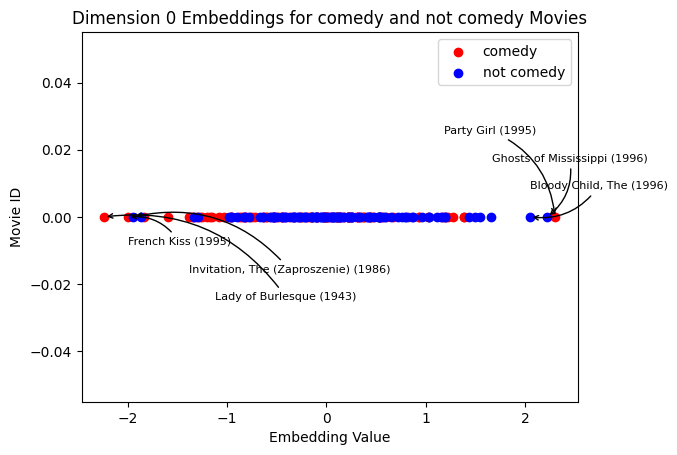

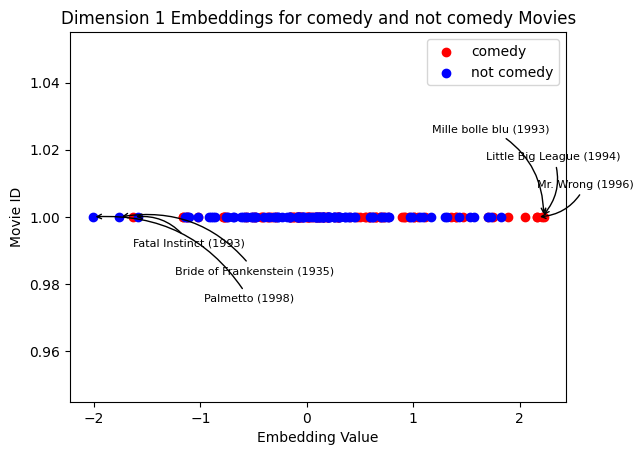

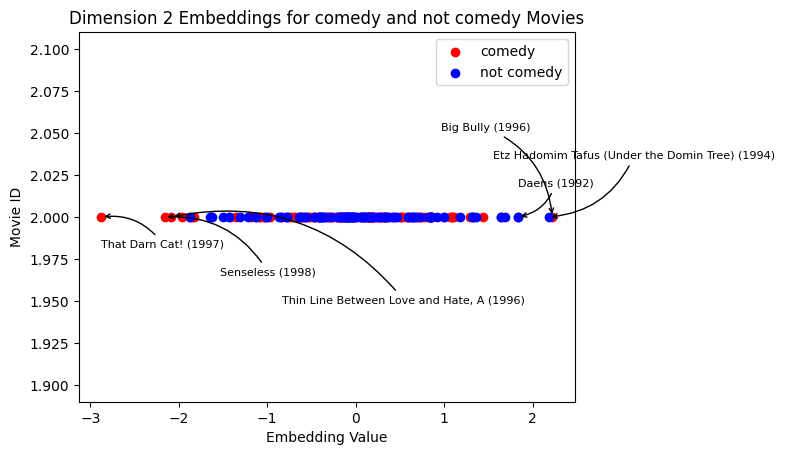

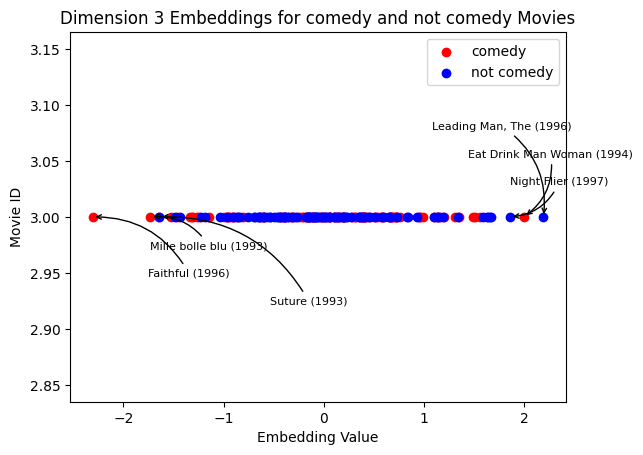

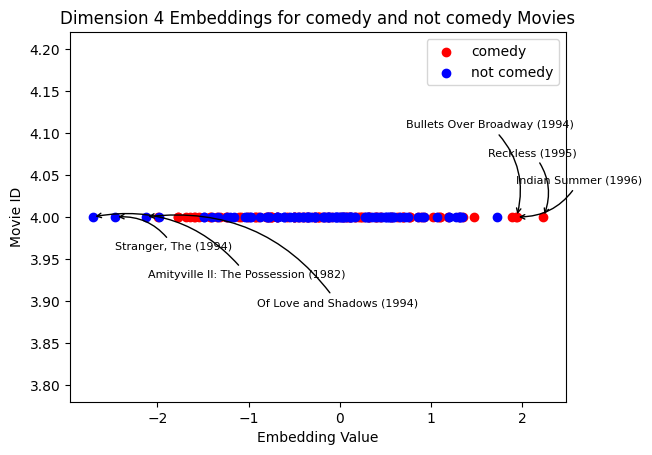

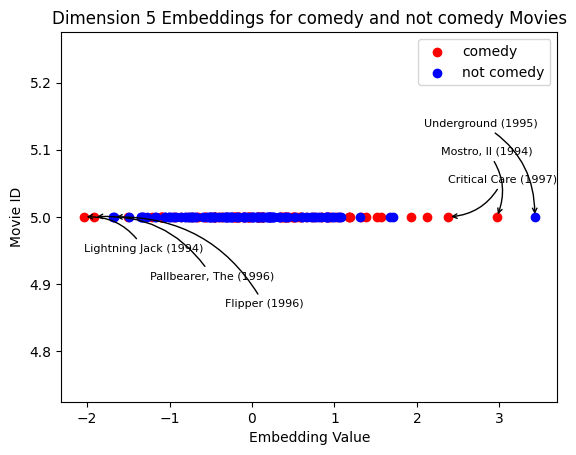

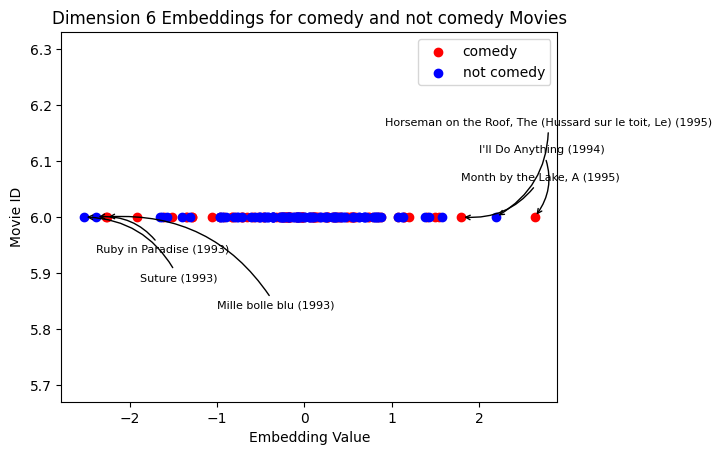

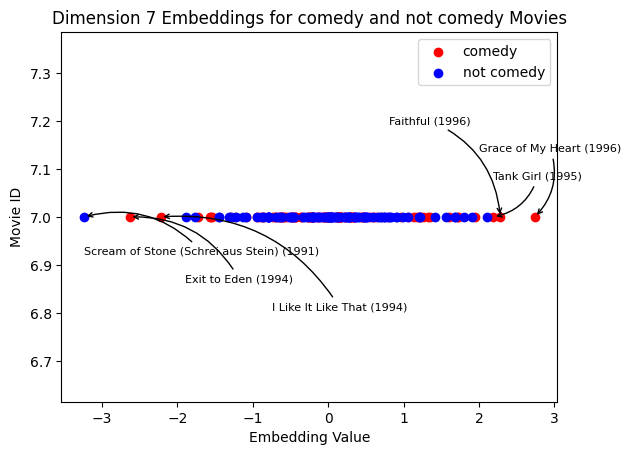

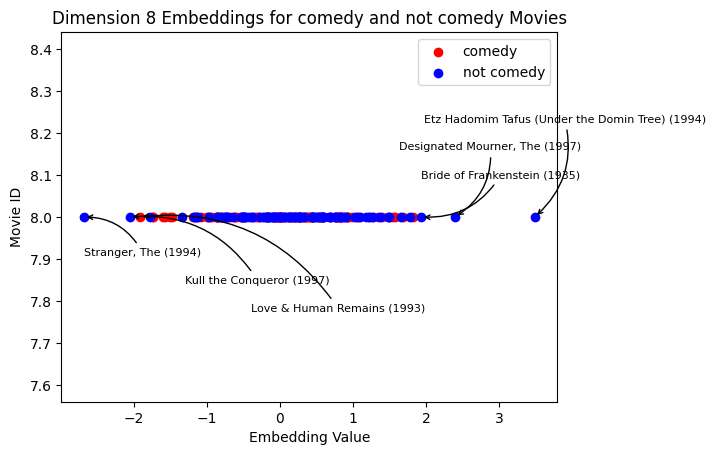

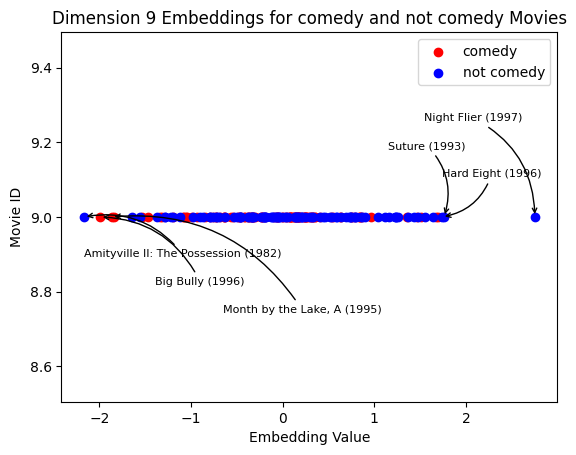

In [133]:
pmf = PMFRecSys()
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
plot_embs_one_genre(pmf.w_Item, moviesDF, "comedy", 100)

No dimensions show clear distinctions.

### (b)

In [134]:
def plot_embs_two_genres(embeddings, moviesDF, genres, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genres: list of strings. (e.g., ['action', 'comedy'])
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """

  genre1 = genres[0]
  genre2 = genres[1]
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre1] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre2] == 1]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre1}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'{genre2}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre1} and {genre2} Movies')
    plt.show()




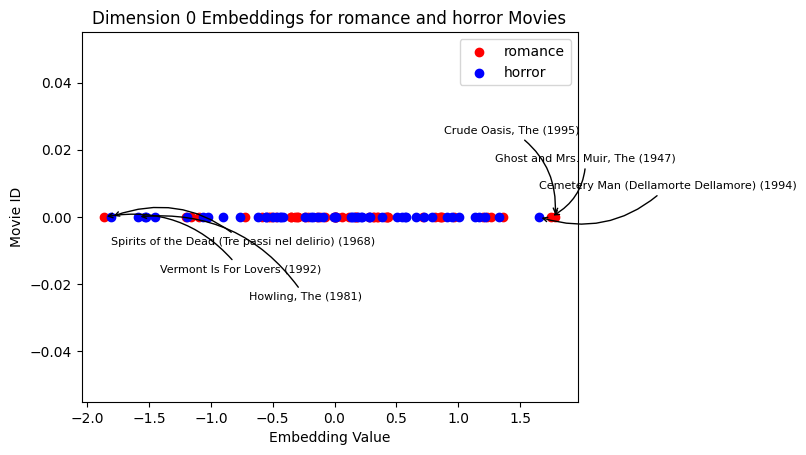

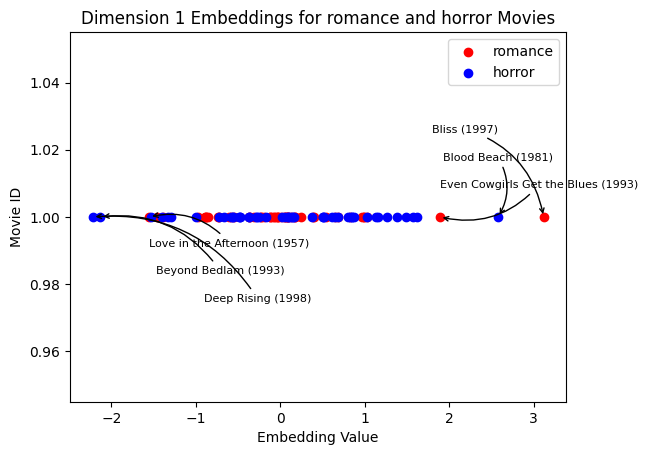

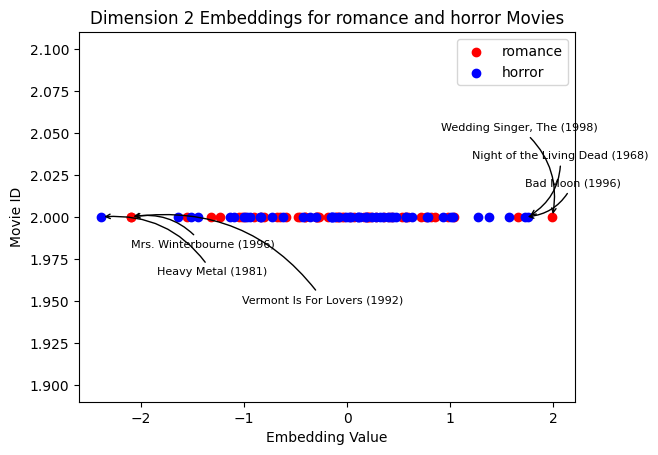

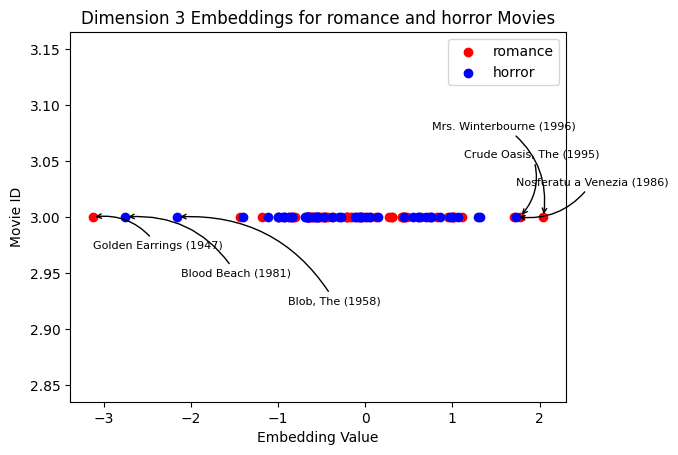

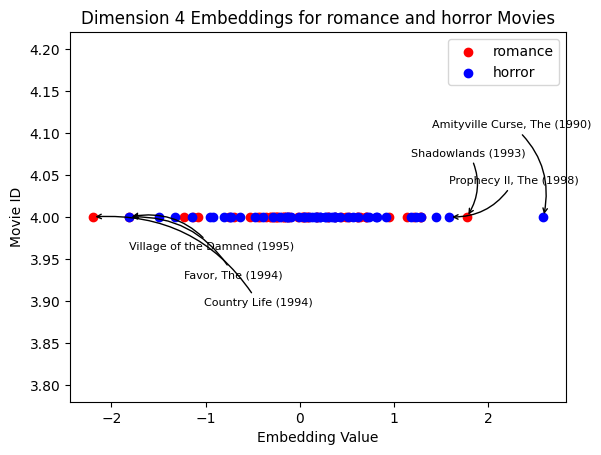

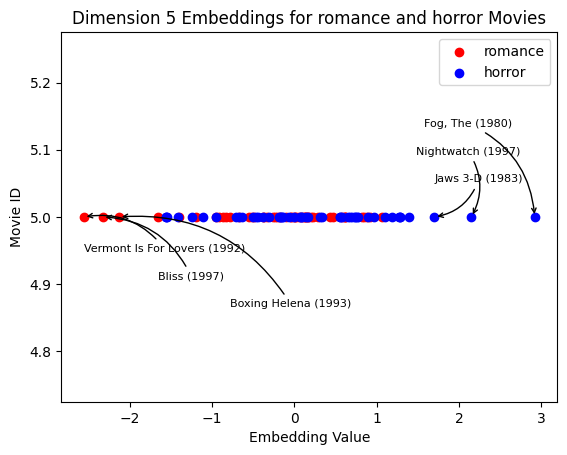

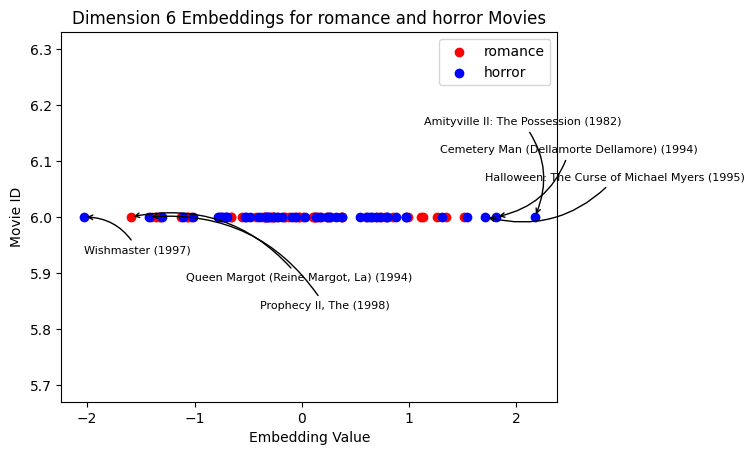

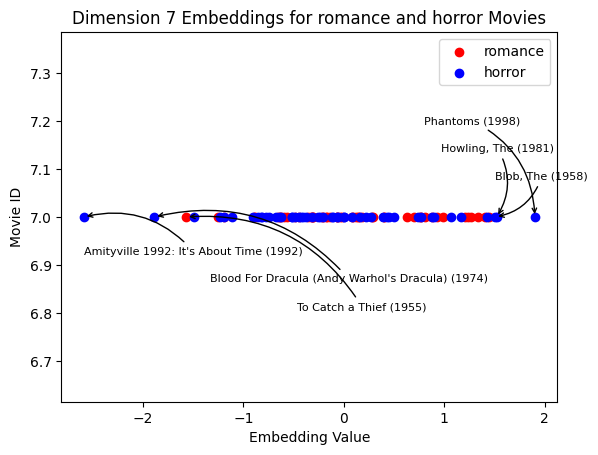

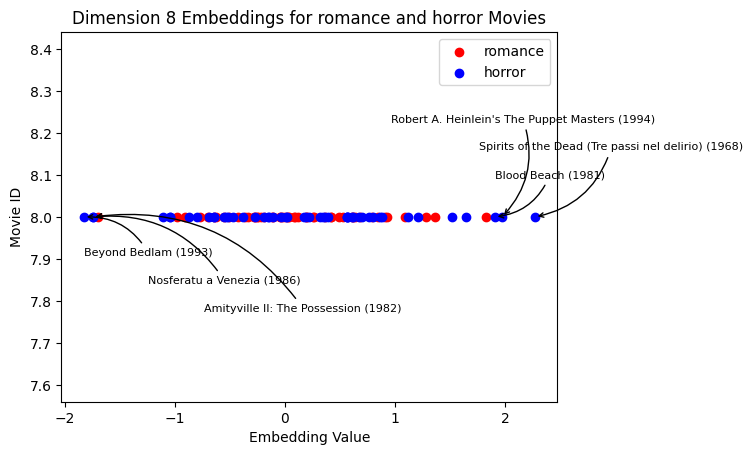

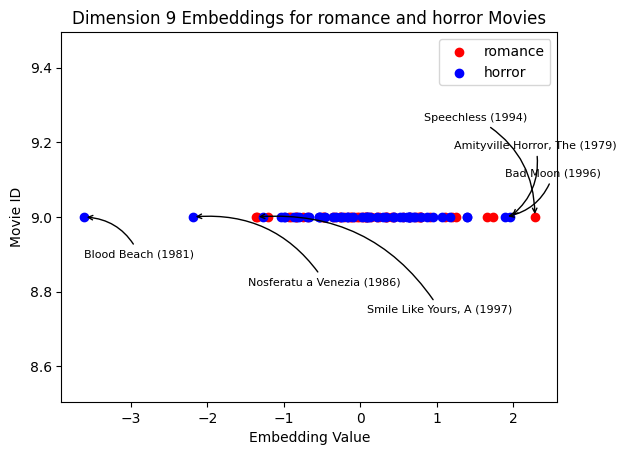

In [136]:
pmf = PMFRecSys()
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
plot_embs_two_genres(pmf.w_Item, moviesDF, ["romance", "horror"], 50)

I dont really see a considerable difference. I expected the two to be different as someone who likes romance may not be interested in horror.

# Validation

In [137]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [138]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [139]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [140]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [141]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [142]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    #useraverage_recsys = BaseLineRecSys('average_user_rating')
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [143]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [144]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [145]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [146]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [147]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [148]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [149]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [150]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [151]:
validateIISimBasedRecSys()

In [152]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return

    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [153]:
validatePMFRecSys(validation_df=validation_df)